# Procesos estocásticos en tiempo continuo

El ajuste a datos reales se logra con reescalamiento y combinación de procesos simulados de Weiner.
Empiezo por simulación de procesos individuales.


# Movimiento Browniano

### Convenciones:
Matriz de d trayectorias de una serie de n tiempos será matriz d x n. 


Trayectoria==individuo, cada tiempo una variable

Simulación de browniano:
$$B_{t+1}=B_t+\sqrt{t} Z_t, \quad Z_t~N(0,1)$$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
import brownian_motion as bm

size dB:  10000 0.0001
var B:  9.926341591617451e-05


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

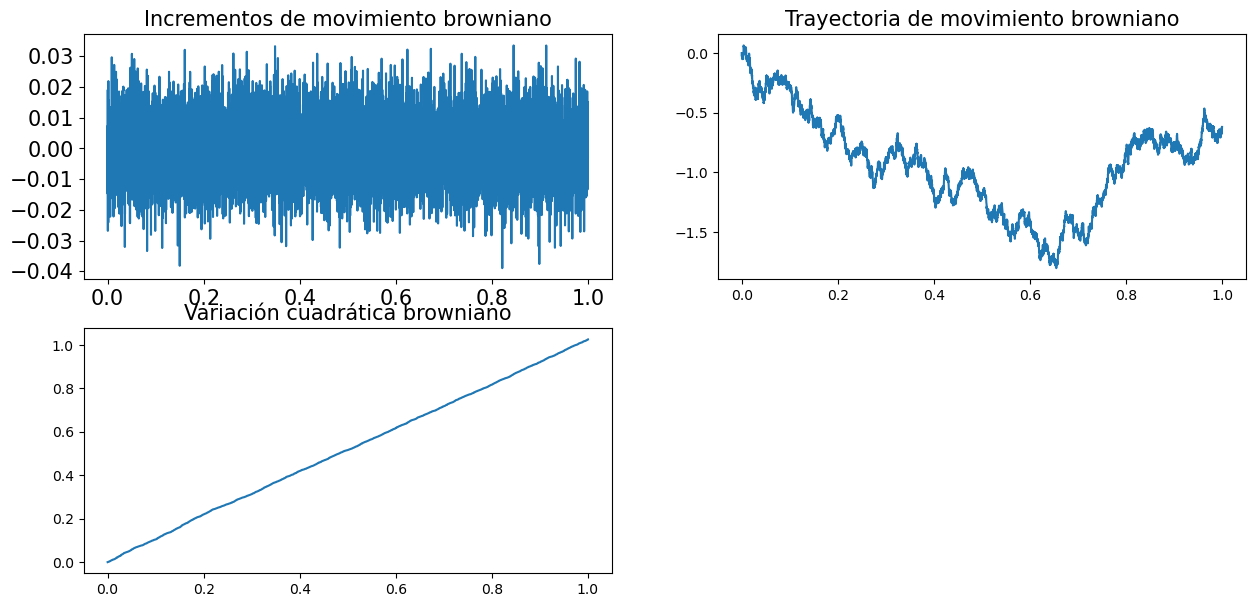

In [5]:
#simulación individual

T=1#Horizonte de tiempo
s=9999 # num de subintervalos
n=s+1 #número de puntos
time=np.linspace(0,T,n)#Con n=s+1 puntos obtengo 0=t_0<...<t_n=T, s subintervalos
dt=T/n

dB=bm.get_dB(n,dt=dt)#,random_state=5)
print("size dB: ", dB.size,dt)
B=bm.get_B(n,dt=dt)#,random_state=5) 
print("var B: ",np.var(dB))

# dB = get_dB(1_000)

# B  = get_B(1_000)

fig = plt.figure(figsize=(15, 7))

title = "Incrementos de movimiento browniano"
plt.subplot(2, 2, 1)
plt.plot(time,dB.T) #basta plt.plot(dB.T) si el dt=1
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Trayectoria de movimiento browniano"
plt.subplot(2, 2, 2)
plt.plot(time, B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

title = "Variación cuadrática browniano"
plt.subplot(2, 2, 3)
plt.plot(time,bm.quadratic_variation(B).T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Simulación de matriz de trayectorias
(dxn). d trayectorias con n muestreos (n y dt dados)

# Parámetros y función de plot

In [17]:
T=10
s=999 # número de subint
n=s+1 # número de puntos
d=500 # núm de tratectorias
time=np.linspace(0,T,n) 
dt=T/n


#Función de plot:
def plotear(nombre_proceso, mu_teor_t,mu_hat_t, var_teor_t,var_hat_t,mu_error,var_error,lim_err=[0,1]):
    fig = plt.figure(figsize=(15, 7))
    # paths
    title = f"Comparación media teórica y empírica {nombre_proceso}"
    plt.subplot(2, 2, 1)
    plt.plot(time, np.array([mu_teor_t,mu_hat_t]).T)
    plt.legend(["media teórica","media empírica"])
    plt.gca().set_title(title, fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    #correlation
    title = f"Comparación varianza teórica y empírica {nombre_proceso}"
    plt.subplot(2, 2, 2)
    # sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
    plt.plot(time,np.array([var_teor_t,var_hat_t]).T)
    plt.legend(["varianza teórica","varianza empírica"])
    plt.gca().set_title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


    plt.subplot(2, 2, 3)
    # sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
    plt.plot(time,np.array(mu_error).T)
    plt.legend(["Error en media simulada y teórica"])
    plt.ylim(lim_err)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.subplot(2, 2, 4)
    # sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
    plt.plot(time,np.array(var_error).T)
    plt.legend(["Error en varianza simulada y teórica"])
    plt.ylim(lim_err)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

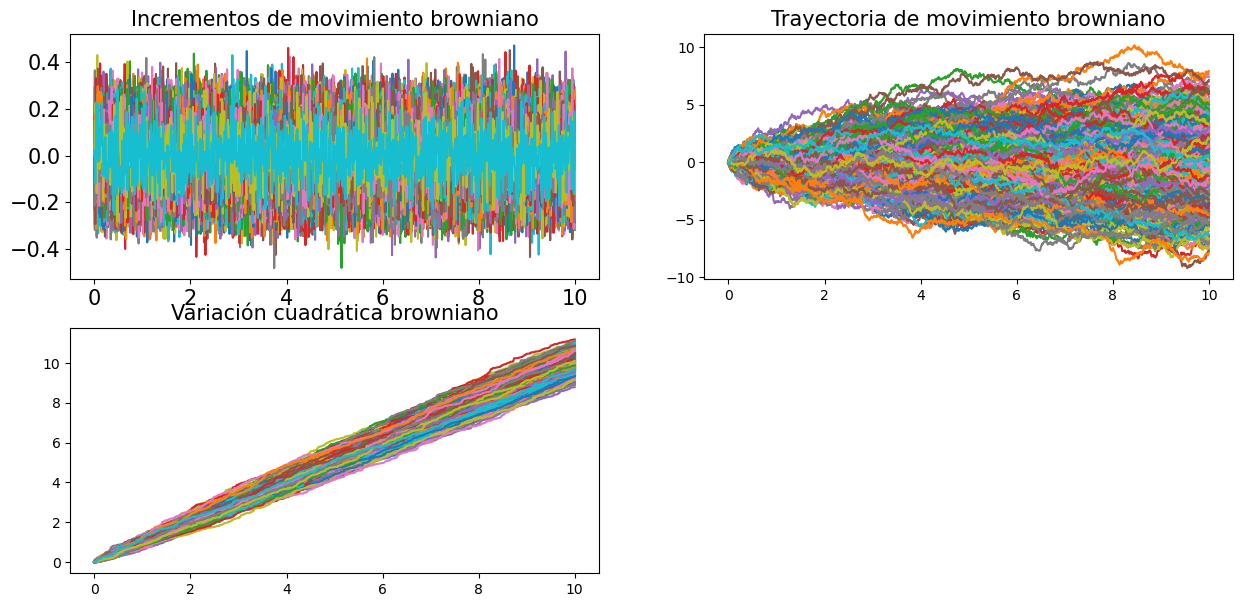

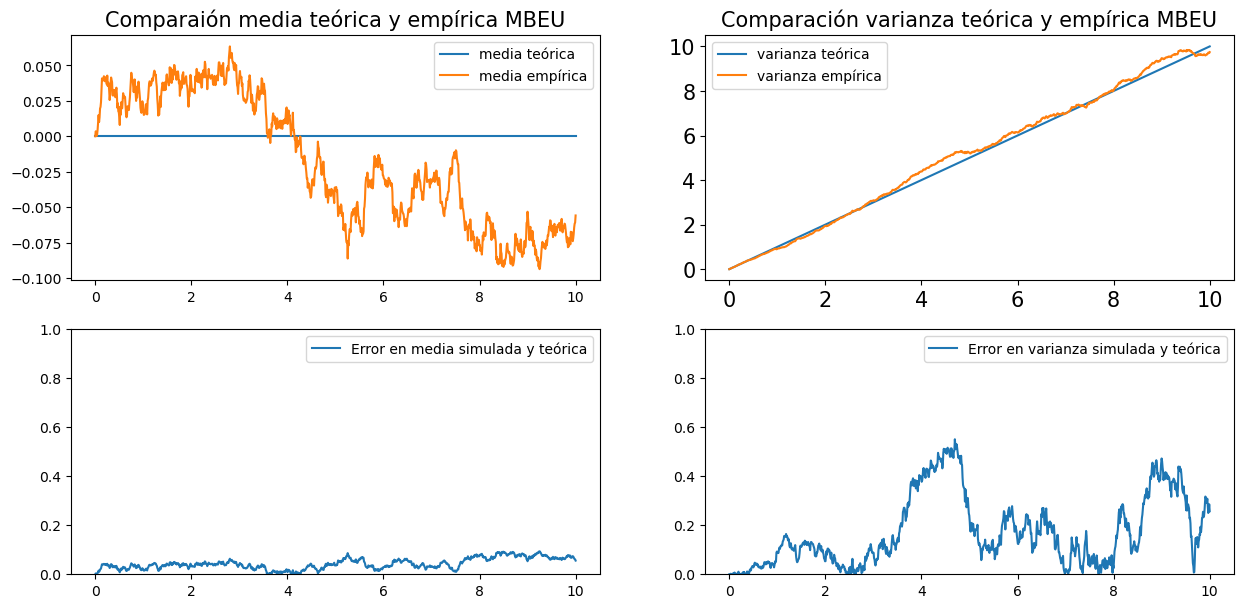

In [7]:
B=bm.get_B_matrix(n,d,dt)
dB=bm.dif_B(B)

fig = plt.figure(figsize=(15, 7))

title = "Incrementos de movimiento browniano"
plt.subplot(2, 2, 1)
plt.plot(time,dB.T) #basta plt.plot(dB.T) si el dt=1
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Trayectoria de movimiento browniano"
plt.subplot(2, 2, 2)
plt.plot(time, B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

title = "Variación cuadrática browniano"
plt.subplot(2, 2, 3)
plt.plot(time,bm.quadratic_variation(B).T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#Comparación teórica y simulada de media, varianzas y covarianzas
mu_hat_t,cov_hat_st=bm.empiric_mu_cov(B)
mu_teor_t,cov_teor=bm.mbeu_theoret_mu_cov(time)

var_hat_t=np.diag(cov_hat_st)
var_teor_t=np.diag(cov_teor)

mu_error=bm.error(mu_hat_t,mu_teor_t)
var_error=bm.error(var_hat_t,var_teor_t)


#plot
plotear("MBEU", mu_teor_t,mu_hat_t,var_teor_t,var_hat_t,mu_error,var_error)


### Correlacionados y matriz de d trayectorias
$W_3$ correlacionado con $W_1$. Con la relación $$dW_3(t)=\rho dW_1(t)+\sqrt{1-\rho^2}dW_2(t)$$
Se tiene que $corr(W_1,W_3)=\rho$.

Usualmente necesitaré múltiplos procesos. El segundo proceso correlacionado por $\rho$ con el primero, el segundo correlacionado por $\rho$ con una elección aleatoria de los procesos ya generados. Simularé una matriz con cada columna como un proceso browniano. 

La matriz será (dxn). Con $\rho=0$ o None, tengo d trayectorias independientes.

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

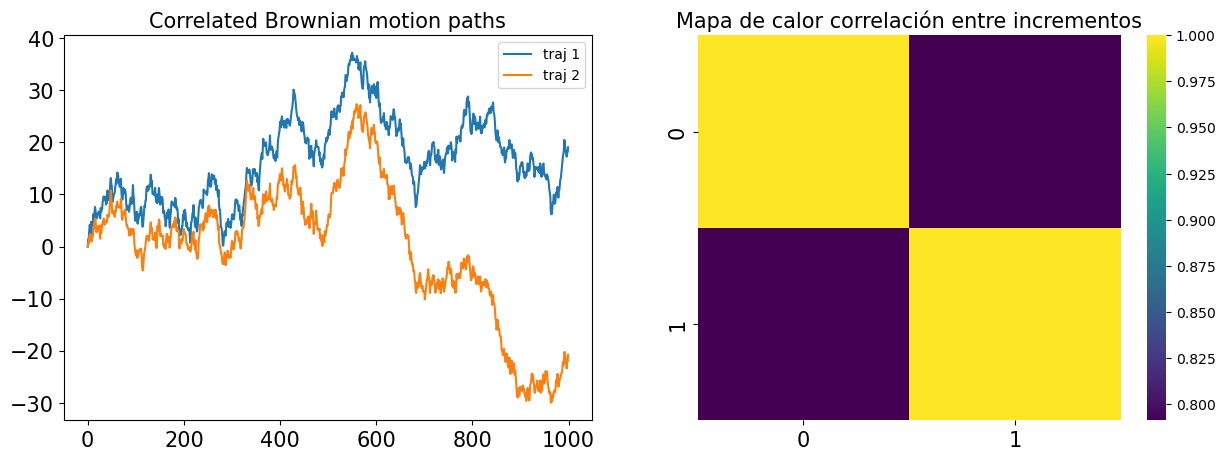

In [8]:
T = 1_000 
#dt =1 --> T=n
n_procs = 2
rho = 0.8

#En caso de usar dt
corr_Bs = bm.get_B_matrix(T, n_procs,rho=rho)
corr_dBs=bm.dif_B(corr_Bs)

#Plot
fig = plt.figure(figsize=(15, 5))
# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(corr_Bs.T)
plt.legend(["traj 1","traj 2"])
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Mapa de calor correlación entre incrementos"
plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
sns.heatmap(np.corrcoef(corr_dBs, rowvar=True), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# title = "Mapa de calor correlación entre trayectorias"
# plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
# plt.gca().set_title(title, fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)



## Medidas de error

In [6]:

print(np.linspace(0,n,n+1).shape)
    
    

###Medidas de error:
def mse(y:np.array,y_hat:np.array)->float:
    return np.mean(np.square(y-y_hat))

def mae(y:np.array,y_hat:np.array)->float:
    return np.mean(np.abs(y-y_hat))


(10002,)


# Movimientos asociados




###  Movimiento browniano bridge   


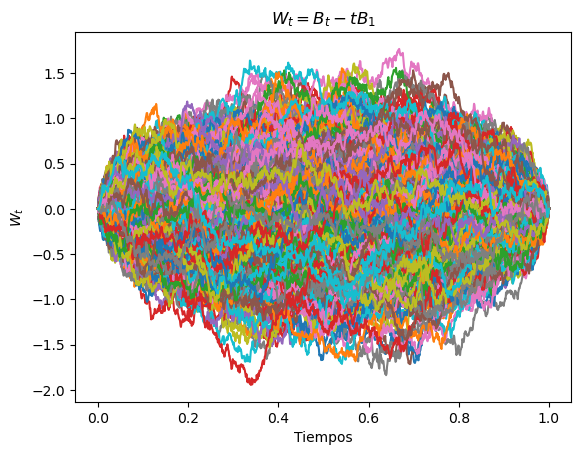

(1001,) (1001,)
Var:  0.0009957507521999474


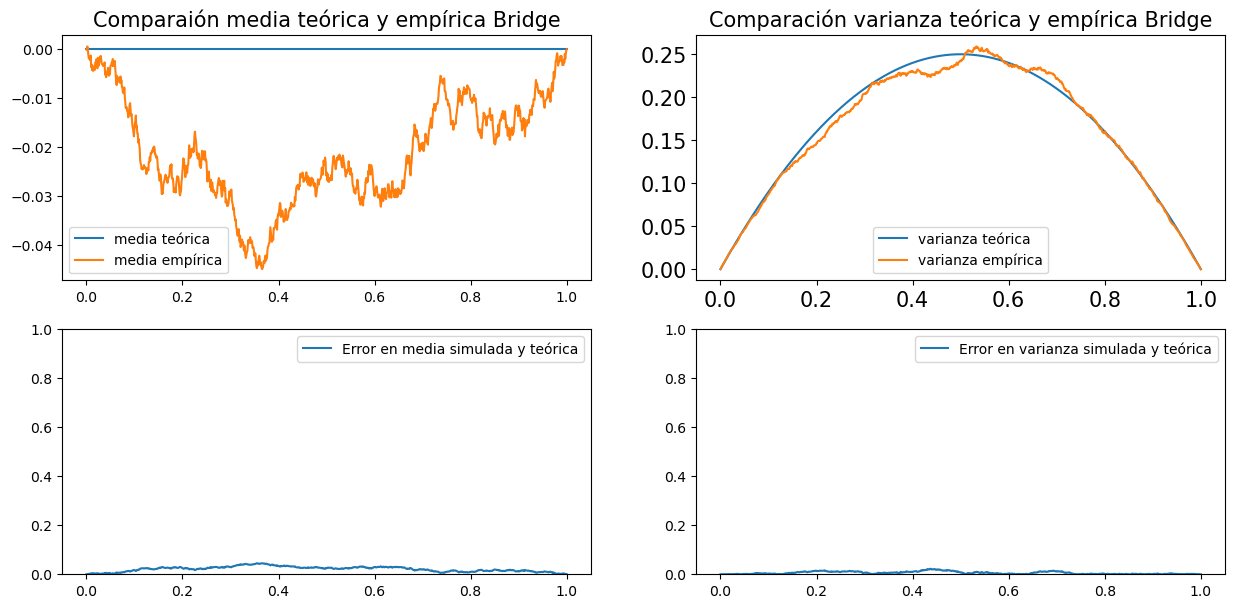

In [9]:
T=1
n=1000
dt=T/n
d=1000
time=np.linspace(0,1,n+1)
Bridge=bm.get_Bridge_matrix(n+1,d)
# Graficamos el movimiento browniano de Bridge
fig, ax = plt.subplots()
ax.plot(time,Bridge.T)
ax.set_title("$W_t = B_t -tB_1$")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show() 



#Medidas empíricas de centraldiad y dispersión:
#Media: (cada columna (Bridge[:,i]) es muestra de W_t para t=i*dt)
#Covarianza
    
x,y=time,time

mu_hat_t,cov_hat_st=bm.empiric_mu_cov(Bridge)
mu_teor_t,cov_teor=bm.bridge_theoret_mu_cov(time)

var_hat_t=np.diag(cov_hat_st)
var_teor_t=np.diag(cov_teor)

mu_error=bm.error(mu_hat_t,mu_teor_t)
var_error=bm.error(var_hat_t,var_teor_t)

print(mu_hat_t.shape, var_hat_t.shape, )
#Plot
plotear("Bridge", mu_teor_t,mu_hat_t,var_teor_t,var_hat_t,mu_error,var_error)

dBridge=bm.dif_B(Bridge)
print("Var: ", np.var(dBridge)) #Verifico que la varianza de los incrementos es la adecuada.




### Ruido gaussiano blanco (coloreado?)

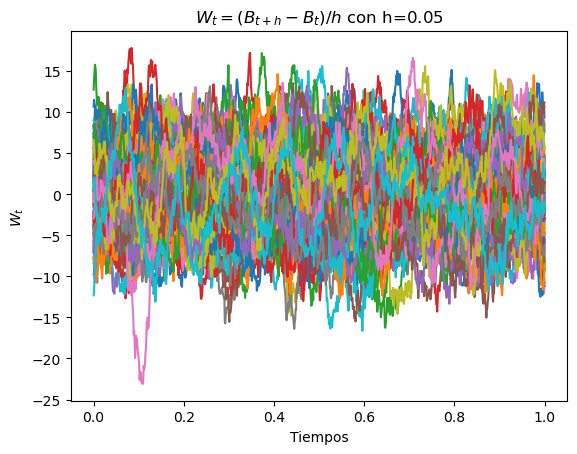

Size var_hat: 1001, size var_teor_
matriz de cov


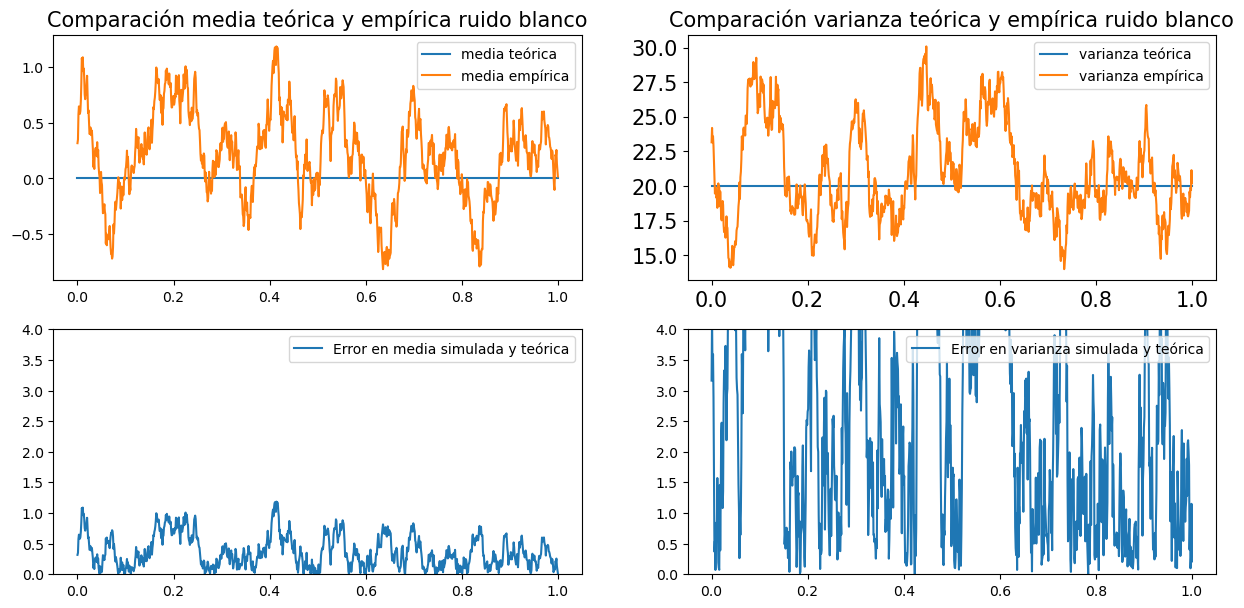

In [18]:
T=1
n=1000
dt=T/n
h=50
h_dt=h*dt#Es el incremento h real
time=np.linspace(0,T,n+1)
d=100
Wn=bm.get_w_noise_matrix(n+1,d,h=h,dt=dt)


fig, ax = plt.subplots()
ax.plot(time,Wn.T)
ax.set_title("$W_t= (B_{t+h} -B_t)/h$ "+f"con h={h_dt}")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()




mu_teor_t,cov_teor=bm.w_noise_theoret_mu_cov(time,h=h,dt=dt)
mu_hat_t,cov_hat=bm.empiric_mu_cov(Wn)

var_hat_t=np.diag(cov_hat)
var_teor_t=np.diag(cov_teor)

print(f"Size var_hat: {var_hat_t.size}, size var_teor_")
mu_error=bm.error(mu_hat_t,mu_teor_t)
var_error=bm.error(var_hat_t,var_teor_t)



#Plot
plotear("ruido blanco",mu_teor_t,mu_hat_t,var_teor_t,var_hat_t,mu_error,var_error,lim_err=[0,4])
print("matriz de cov")

### Browniano drift

In [ ]:
def get_drift_matr(n:int,d:int,mu:float,sigma:float,T)->np.array:
    dt=T/n
    B=bm.get_B_matrix(n,d,dt=dt)
    

